# Example spot-variation FCS

Load packages

In [15]:
from brighteyes_ffs.fcs.fcs2corr import fcs_load_and_corr_split as correlate
from brighteyes_ffs.fcs.fcs2corr import fcs_av_chunks
from brighteyes_ffs.fcs.filter_g import good_chunks_from_g_obj as good_chunks_idx
from brighteyes_ffs.fcs.fcs_fit import fcs_fit
from brighteyes_ffs.fcs.get_fcs_info import get_metafile_from_file, get_file_info
from brighteyes_ffs.fcs_gui.timetrace_end import timetrace_end
from brighteyes_ffs.tools.fit_curve import fit_curve
from brighteyes_ffs.tools.stokes_einstein import stokes_einstein
from brighteyes_ffs.fcs_gui.read_ffs import read_g_from_ffs
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

File name and correlation options to calculate.

list_of_g is a list of correlations to calculate. Options are
* predefined keywords, such as 'central', 'sum3', 'sum5' for channel 12, sum3x3, and sum5x5, respectively
* integers for the autocorrelation of a single channel, e.g., 12 for the central element ACF
* define the ACF of a custom sum of detector elements as a string starting with C, e.g., 'C6+7+8+11+12+13+16+17+18' is the same as 'sum3'
* define the CCF as a string starting with 'x' followed by the two channels to cross-correlate, e.g., 'x0512' for the CCF between elements 5 and 12

In [19]:
file = r'Y:\Data MMS server\FCS_Setup\NIsystem\2025\2025-04-30_beads\01_20nmbeads_488_LP57_y_100_x_100.bin'
list_of_g = ['central', 'sum3', 'sum5']
algorithm = 'multipletau' #'multipletau' for time-domain calculation, 'wiener-khinchin' for fft based calculation
accuracy = 20 # the higher this number, the more points the correlation will have
chunksize = 1 # split the data in segments of this length (in seconds) and calculate the ACF for each segment separately
time_trace = True # return also the intensity time trace

In [20]:
mdata = get_file_info(get_metafile_from_file(file))

## Calculate correlations

In [21]:
G, time_trace = correlate(file, list_of_g=list_of_g, algorithm=algorithm, accuracy=accuracy, split=chunksize, time_trace=time_trace)

+--------------------+
| Loading chunk 1/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> central: Calculating autocorrelation central detector element
     --> sum3: Calculating autocorrelation sum3x3
     --> sum5: Calculating autocorrelation sum5x5
+--------------------+
| Loading chunk 2/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> central: Calculating autocorrelation central detector element
     --> sum3: Calculating autocorrelation sum3x3
     --> sum5: Calculating autocorrelation sum5x5
+--------------------+
| Loading chunk 3/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> central: Calculating autocorrelation central detector element
     --> sum3: Calculating autocorrelation sum3x3
     --> sum5: Calculating autocorrelation sum5x5
+--------------------+
| Loading chunk 4/60 |
+--------------------+
data table: (100000, 2)
Converting data to 

### Plot time-trace

The time-trace is a compressed data set of max. 1000 time points per channel. Depending on the chunksize, some padded zeros may appear at the end of the time trace due to rounding errors.

In [22]:
num_chunks = int(np.floor(mdata.duration / chunksize))
splits = np.arange(0, (num_chunks+1)*chunksize, chunksize)

Text(0, 0.5, 'Photon counts per bin')

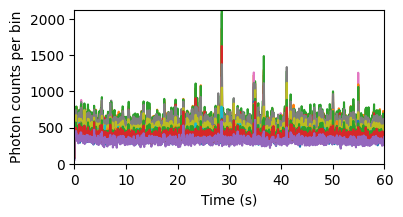

In [25]:
n_t = timetrace_end(time_trace) # time_trace is a compressed version of the actual time_trace with between 900-1000 data points
time = np.linspace(0, mdata.duration, n_t)

fig, ax = plt.subplots(figsize=(4,2))
for i in range(25):
    plt.plot(time, time_trace[0:n_t,i])
ymin = np.min(time_trace)
ymax = np.max(time_trace)

plt.xlim([0, mdata.duration])
plt.ylim([ymin, ymax])
plt.xlabel('Time (s)')
plt.ylabel('Photon counts per bin')

### Plot correlations

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


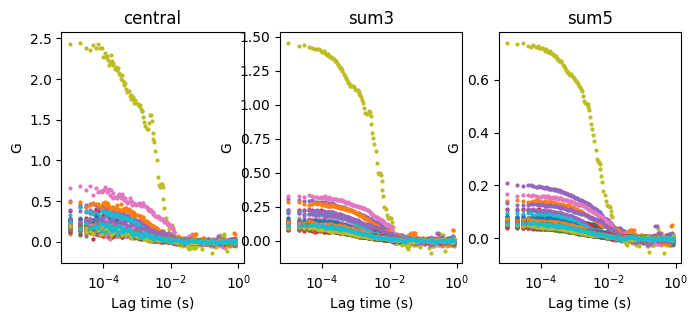

In [26]:
num_chunks = G.num_chunks

f, axs = plt.subplots(1, len(list_of_g), figsize=(8,3))

for i, corr in enumerate(list_of_g):
    for j in range(num_chunks):
        Gsingle = getattr(G, corr + '_chunk' + str(j))
        axs[i].scatter(Gsingle[1:,0], Gsingle[1:,1], s=4, label='chunk ' + str(j))
    axs[i].set_xscale('log')
    axs[i].set_title(corr)
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_ylabel('G')

### Average over good chunks

Some chunks look bad. Write a list with the good chunks only and average over those. The good chunks can be found automatically (beta version) by looking at the sum5 correlation and accepting only the 66 percent best correlations.

In [27]:
idx = good_chunks_idx(G, filt='sum5', f_acc=0.66) # look at the sum5 and accept 66 percent
G.average_chunks(idx) # average good chunks

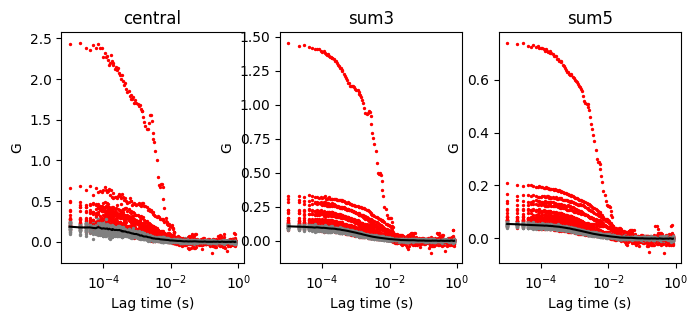

In [28]:
f, axs = plt.subplots(1, len(list_of_g), figsize=(8,3))

for i, corr in enumerate(list_of_g):
    for j in range(num_chunks):
        Gsingle = getattr(G, corr + '_chunk' + str(j))
        c='r'
        if j in idx:
            c='gray'
        axs[i].scatter(Gsingle[1:,0], Gsingle[1:,1], s=2, label='chunk ' + str(j), c=c)
    axs[i].set_xscale('log')
    axs[i].set_title(corr)
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_ylabel('G')
    axs[i].plot(Gsingle[1:,0], getattr(G, corr + '_averageX')[1:,1], 'k')

## Fit correlations

### Fit 1 component 3D diffusion Gaussian volume

For fitfun = 'fitfun_2c', the order of the parameters for fitting is
* N: number of particles in focal volume [dim.less]
* tauD1: diffusion time species 1 [ms]
* tauD2: diffusion time species 2 [ms]
* F: fraction of species 1 [dim.less]
* alpha: relative molecular brightness [dim.less]
* T: fraction in triplet [dim.less]
* tautrip: residence time in triplet state [µs]
* SF: shape factor [dim.less]
* offset  [dim.less]
* A, B    afterpulsing properties

In [8]:
start_idx = 2 # start index of the fit
stop_idx = 141 # stop index

fitfun = 'fitfun_2c'
fit_info = np.asarray([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # fit N and tauD (we fit with one component)
lBounds  = np.asarray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])*(-1e6) # lower bounds for all parameters
uBounds  = np.asarray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])*(1e6) # upper bounds for all parameters
param    = np.asarray([1.0, 1, 1, 1, 0, 0, 1, 5, 0, 0, 0]) # starting values for all parameters

Gall, tau, Gstd = G.get_av_corrs(G.list_of_g_out, av='_averageX')
Gall = Gall[start_idx:stop_idx,:]
tau = tau[start_idx:stop_idx]

fitresults = []
for i in range(len(list_of_g)):
    fitresult = fcs_fit(Gall[:, i], tau, fitfun, fit_info, param, lBounds, uBounds, plotInfo=-1)
    fitresults.append(fitresult)

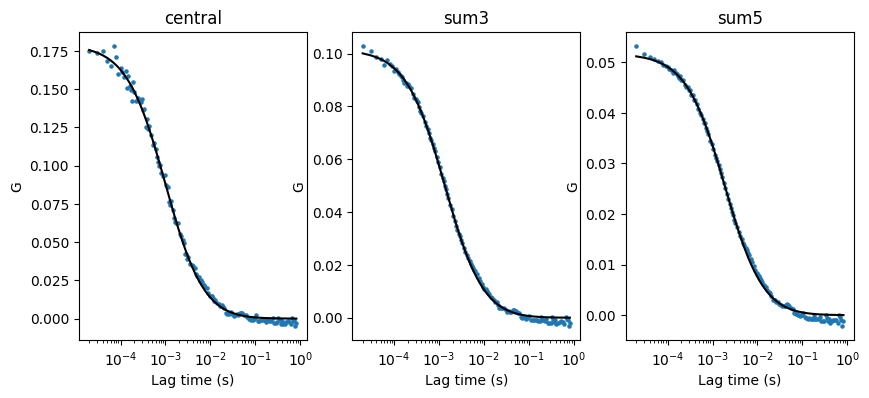

In [10]:
f, axs = plt.subplots(1, len(list_of_g), figsize=(10,4))

for i, corr in enumerate(list_of_g):
    axs[i].scatter(tau, Gall[:,i], s=5, label=corr)
    axs[i].plot(tau, Gall[:,i]-fitresults[i].fun, c='k')
    axs[i].set_xscale('log')
    axs[i].set_title(corr)
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_ylabel('G')

In [11]:
for i, corr in enumerate(list_of_g):
    fitresult = fitresults[i]
    print(corr)
    print(f"N = {fitresult.x[0]:.2f}")
    print(f"tau_D = {fitresult.x[1]:.2f} ms\n")
# fitresult.fun

central
N = 5.58
tau_D = 1.00 ms

sum3
N = 9.84
tau_D = 1.36 ms

sum5
N = 19.34
tau_D = 1.90 ms



### Fit diffusion law

Text(0, 0.5, 'Diffusion time (ms)')

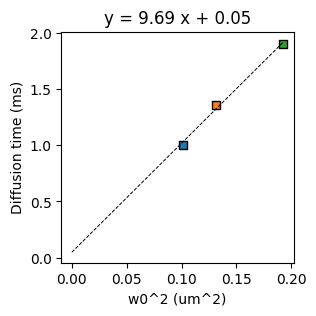

In [12]:
taufit = [fitresult.x[1] for fitresult in fitresults]
w0 = 1e-3*np.asarray([318, 362, 439])
fitresult = fit_curve(taufit, (w0)**2, 'linear', [1, 1], [1, 1], [-1e6, -1e6], [1e6, 1e6], savefig=0)

plt.figure(figsize=(3,3))
for i in range(len(taufit)):
    plt.scatter(w0[i]**2, taufit[i], edgecolors='k', marker='s')
w02fit = np.zeros(len(w0) + 1)
w02fit[0] = 0
w02fit[1:] = w0**2
taufitres = np.zeros(len(w0) + 1)
taufitres[0] = fitresult.x[1]
taufitres[1:] = taufit - fitresult.fun
if fitresult.x[1] < 0:
    fitlabel = 'y = {A:.2f} x {B:.2f}'.format(A=fitresult.x[0], B=fitresult.x[1])
else:
    fitlabel = 'y = {A:.2f} x + {B:.2f}'.format(A=fitresult.x[0], B=fitresult.x[1])
plt.plot(w02fit, taufitres, '--', color='k', linewidth=0.7, label=fitlabel, zorder=1)
plt.title(fitlabel)
plt.xlabel('w0^2 (um^2)')
plt.ylabel('Diffusion time (ms)')

In [13]:
T = 293  # temperature in K
visc = 1e-3  # viscosity in Pa.s

for i in range(3):
    D = 1e12 * (1e-6 * w0[i])**2 / (4 * (1e-3 * taufit[i]))
    diameter = 1e9 * stokes_einstein(1e-12 * D, T, visc)
    print(f"Diffusion coefficient: {D:.2f} um^2/s --> diameter: {diameter:.2f} nm")

Diffusion coefficient: 25.26 um^2/s --> diameter: 16.99 nm
Diffusion coefficient: 24.10 um^2/s --> diameter: 17.81 nm
Diffusion coefficient: 25.32 um^2/s --> diameter: 16.95 nm


### Fit with 200 components maximum entropy method

In [14]:
from brighteyes_ffs.fcs.mem_fit import mem_fit_free_diffusion

In [15]:
n_comp = 200 # number of diffusion times
corr_vs_entropy = 20.0 # weight of the correlation vs. weight of the entropy
shape_parameter = 4 # z0/w0
max_iter = 10000.0 # maximum number of iterations in the fit

fitresults_mem = []
for corr in list_of_g:
    Gsingle = getattr(G, corr + '_averageX')
    Gexp = Gsingle[start_idx:stop_idx,1]
    tau = Gsingle[start_idx:stop_idx,0]
    fitfun = mem_fit_free_diffusion
    fit_info = np.asarray([False, False, False, False, False, False, False])
    param = np.asarray([n_comp, max_iter, 5e-06, 0.0002, 1.0, corr_vs_entropy, shape_parameter])
    lBounds = np.asarray([0, 0, 0, 0, 0, 0, 0]) # the lower bounds for the fit parameters
    uBounds = np.asarray([1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0]) # the upper bounds for the fit parameters
    
    fitresult = fcs_fit(Gexp, tau, fitfun, fit_info, param, lBounds, uBounds, plotInfo=-1)
    fitresults_mem.append(fitresult)

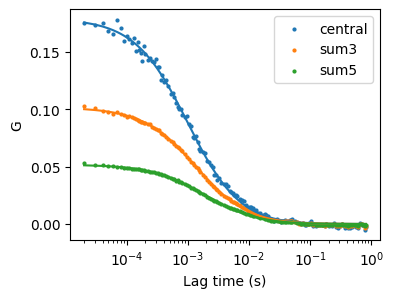

In [16]:
plt.figure(figsize=(4,3))
for i, corr in enumerate(list_of_g):
    # plot correlation
    Gsingle = getattr(G, corr + '_averageX')
    plt.scatter(Gsingle[start_idx:stop_idx,0], Gsingle[start_idx:stop_idx,1], s=4, label=corr)
    # plot fit
    fitresult = fitresults[i]
    plt.plot(Gsingle[start_idx:stop_idx,0], Gsingle[start_idx:stop_idx,1]-fitresult.fun)
plt.legend()
plt.xlabel('Lag time (s)')
plt.ylabel('G')
plt.xscale('log')
plt.yscale('linear')

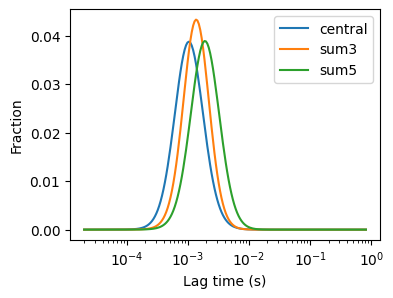

In [17]:
plt.figure(figsize=(4,3))

taumin = np.log10(Gsingle[start_idx,0])
taumax = np.log10(Gsingle[stop_idx-1,0])
tauD = np.logspace(taumin, taumax, n_comp)

for i, corr in enumerate(list_of_g):
    # plot correlation
    fitresult = fitresults_mem[i].x
    plt.plot(tauD, fitresult, label=corr)
plt.legend()
plt.xlabel('Lag time (s)')
plt.ylabel('Fraction')
plt.xscale('log')
plt.yscale('linear')